# Work With Standardized CCF File For ESSP4
Standardized CCFs have filenames of the form: `DS#.###_ccfs_<<inst>>.fits`

For example, the twelfth (012) observation from data set three (3), if taken by the HARPS-N instrument will have the file name: `DS3.012_ccfs_harpsn.fits`

Please see the [ESSP website](https://essp-eprv.github.io/data.html#ccf) for more information

In [1]:
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import seaborn as sns

/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <

In [2]:
# Specify file name
# Specify where all the spectra are saved
ccfs_dir = '/mnt/home/lzhao/ceph/SolarData/DataSets/Training/DS0/CCFs/'
# For example, to return all files in a data set:
file_list = glob(os.path.join(ccfs_dir,'*.fits'))

# Select a file at random from all files in the data set as example
file = np.random.choice(file_list)

In [3]:
hdus = fits.open(file)
hdus.info()

Filename: /mnt/home/lzhao/ceph/SolarData/DataSets/Training/DS0/CCFs/DS0.124_ccfs_neid.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      15   ()      
  1  V_GRID        1 ImageHDU         7   (61,)   float64   
  2  CCF           1 ImageHDU         7   (61,)   float64   
  3  E_CCF         1 ImageHDU         7   (61,)   float64   
  4  ECHELLE_ORDERS    1 ImageHDU         7   (93,)   int64   
  5  OBO_CCF       1 ImageHDU         8   (61, 93)   float64   
  6  OBO_E_CCF     1 ImageHDU         8   (61, 93)   float64   
  7  OBO_RV        1 ImageHDU         7   (93,)   float64   
  8  OBO_E_RV      1 ImageHDU         7   (93,)   float64   


Each extension is described on the [ESSP website](https://essp-eprv.github.io/data.html#ccf)

In [4]:
# Header information contained in the header of the primary HDU
hdus[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
TIME    =    59346.29346037585 / Time of observation [eMJD]                     
DATE-CCF= '2025-05-05T13:30:40.797' / Time of CCF calculation                   
PIPELINE= 'EXPRES  '                                                            
RV      =   -21.81092734593405 / Best-fit CCF RV in m/s                         
E_RV    =                  0.0 / CCF RV Error m/s                               
MASK    = 'NEID_G2.fits'       / CCF mask file used                             
VRANGE  =                 12.0 / +/- range of velcity in km/s                   
V0      =                  0.0 / Center of velocity grid in km/s                
VSPACING=                  0

## Plot CCF and Order-by-Order (`obo`) CCFs
CCFs plotted here normalized by their maximum value.  (Note: some CCFs will appear discomfortingly noisy because they are low signal; information that is erased through the normalization)

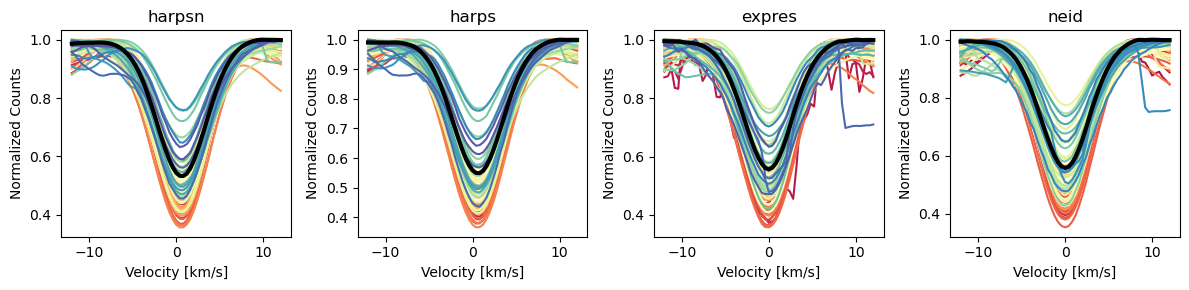

In [5]:
fig, axes = plt.subplots(1,4,figsize=(12,3))
for iinst,inst in enumerate(['harpsn','harps','expres','neid']):
    # Set up a subplot for each instrument
    ax = axes[iinst]
    ax.set_title(inst)
    ax.set_xlabel('Velocity [km/s]')
    ax.set_ylabel('Normalized Counts')
    # Select a random file for each instrument
    file = np.random.choice(glob(os.path.join(ccfs_dir,f'*_{inst}.fits')))
    
    # Read in data
    hdus = fits.open(file)
    num_ord = len(hdus['echelle_orders'].data) # number of orders
    colors = sns.color_palette('Spectral',num_ord) # use num_ord to define a color map
    v_grid = hdus['v_grid'].data.copy() # velocity grid for all CCFs in the file
    ccf = hdus['ccf'].data.copy() # global CCF
    obo_ccf = hdus['obo_ccf'].data.copy() # order-by-order CCFs
    hdus.close()
    
    # Plot Order-by-Order CCFs
    for nord in range(num_ord):
        if np.sum(np.isfinite(obo_ccf[nord]))==0:
            # Skip CCFs with only NaN values
            continue
        ax.plot(v_grid,obo_ccf[nord]/np.nanmax(obo_ccf[nord]),color=colors[nord])
    # Plot global CCF
    ax.plot(v_grid,ccf/np.nanmax(ccf),color='k',lw=3)
fig.tight_layout()

## Resample HARPS/HARPS-N CCFs
The below function will re-sample the CCF velocity grid from 400 km/s to 800 km/s.  A spacing of 800 km/s is more suitable for the resolution of HARPS and HARPS-N.

For more information, see the [ESSP website](https://essp-eprv.github.io/data.html#velocity_sampling).

In [6]:
def resampleCCF(file_name):
    hdus = fits.open(file_name)
    hdu_names = [hdu.name.lower() for hdu in hdus][1:]
    ccf_dict = {}
    for key in hdu_names:
        if key=='echelle_orders':
            data = hdus[key].data
        elif 'obo' in key:
            if 'rv' in key:
                data = hdus[key].data
            else:
                data = hdus[key].data[:,::2]
        else:
            data = hdus[key].data[::2]
        ccf_dict[key] = data.copy()
    return ccf_dict

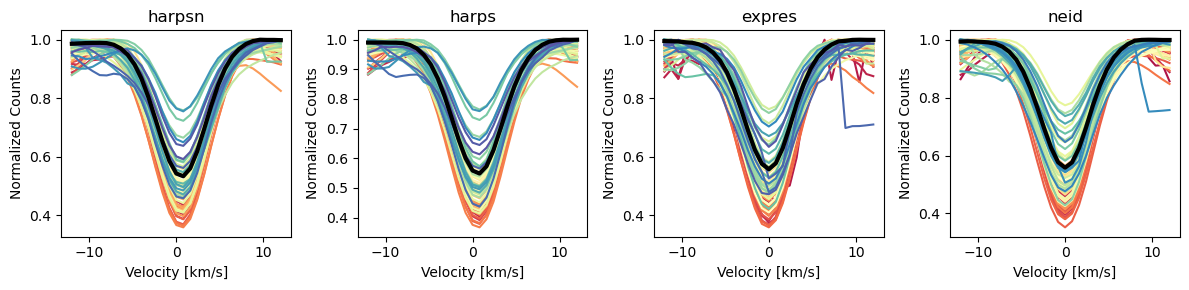

In [7]:
fig, axes = plt.subplots(1,4,figsize=(12,3))
for iinst,inst in enumerate(['harpsn','harps','expres','neid']):
    # Set up a subplot for each instrument
    ax = axes[iinst]
    ax.set_title(inst)
    ax.set_xlabel('Velocity [km/s]')
    ax.set_ylabel('Normalized Counts')
    # Select a random file
    file = np.random.choice(glob(os.path.join(ccfs_dir,f'*_{inst}.fits')))
    
    # Read in data
    ccf_dict = resampleCCF(file)
    num_ord = len(ccf_dict['echelle_orders']) # number of orders
    colors = sns.color_palette('Spectral',num_ord) # use num_ord to define a color map
    v_grid = ccf_dict['v_grid'] # velocity grid for all CCFs in the file
    ccf = ccf_dict['ccf'] # global CCF
    obo_ccf = ccf_dict['obo_ccf'] # order-by-order CCFs
    
    # Plot Order-by-Order CCFs
    for nord in range(num_ord):
        if np.sum(np.isfinite(obo_ccf[nord]))==0:
            # Skip CCFs with only NaN values
            continue
        ax.plot(v_grid,obo_ccf[nord]/np.nanmax(obo_ccf[nord]),color=colors[nord])
    # Plot global CCF
    ax.plot(v_grid,ccf/np.nanmax(ccf),color='k',lw=3)
fig.tight_layout()